# Derived allele frequencies and counts

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

np.random.seed(7)

Plotting setup:

In [2]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [3]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [4]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [5]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

## Load meta data

In [6]:
# easy loading of meta data in a consistent manner across code
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pd.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pd.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Read Mois table with SFS info

In [7]:
derived_counts = pd.read_table('~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/sfs.txt', 
                   names=["pop", "start", "end", "der", "counts"])
derived_counts.head()

,pop,start,end,der,counts
0,NonAfricans,1200000,1300000,0,1
1,NonAfricans,1200000,1300000,1,0
2,NonAfricans,1200000,1300000,2,0
3,NonAfricans,1200000,1300000,3,0
4,NonAfricans,1200000,1300000,4,0


## Read extended sweep regions

In [8]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_10%.hdf')
extended_peak_regions_75 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_75%.hdf')
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / 'extended_peak_regions_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

## Mean count of derived variants

Only at sites with at least some number of derived variants:

In [75]:
min_der = 20

mean_derived_counts = (derived_counts
           .loc[(derived_counts['der'] > min_der) & (derived_counts['counts'] > 0) & \
                (derived_counts['pop'] == "NonAfricans")]
           .groupby(['pop', 'start', 'end'])
           .apply(lambda df: (df.der * df.counts).sum() / df.counts.sum())
           .to_frame('mean_count')
           .reset_index()
          )

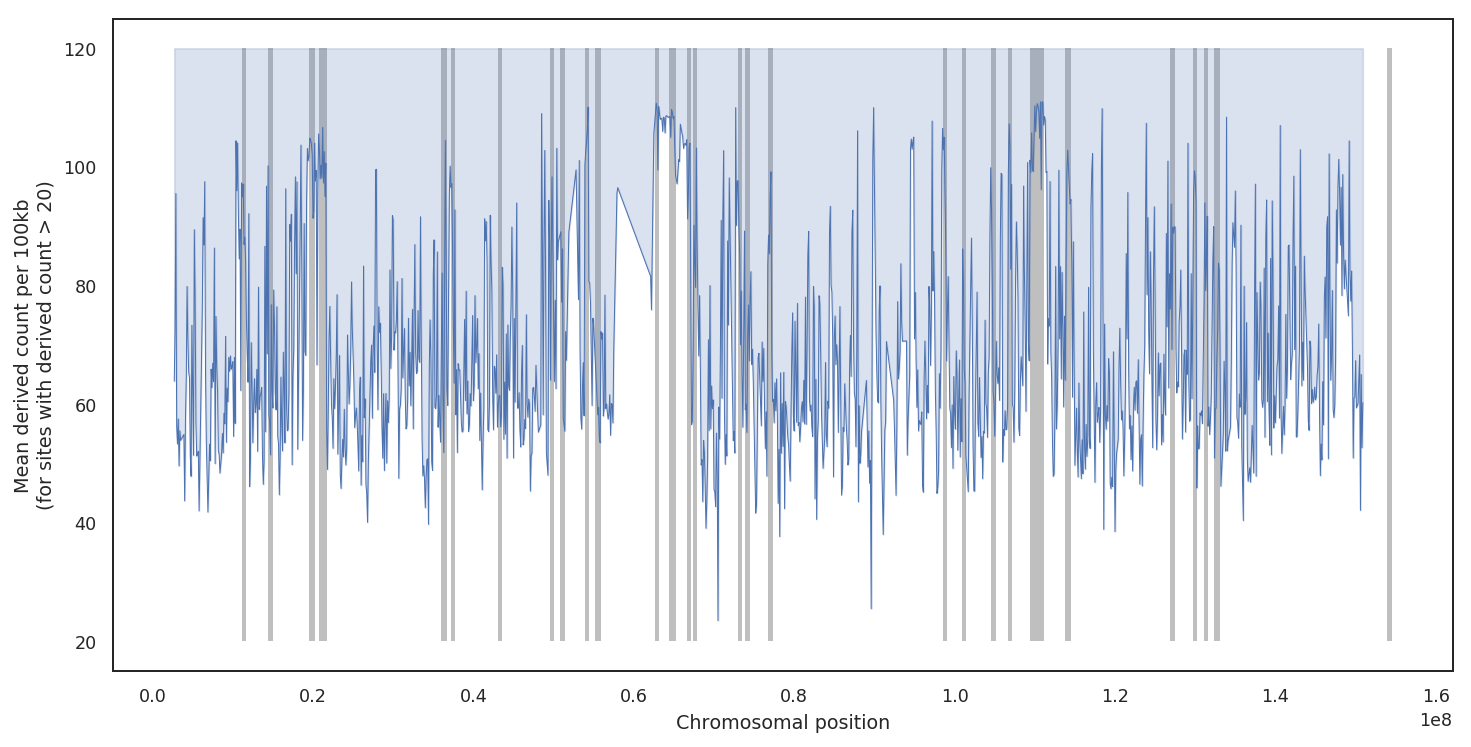

In [75]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
#    ax.scatter(mean_derived_counts.start, mean_derived_counts.mean_count)
    p = ax.plot(mean_derived_counts.start, mean_derived_counts.mean_count, linewidth=0.5)

    for tup in extended_peak_regions_75.itertuples():
        g = ax.add_patch(Rectangle((tup.start_pos, min_der), tup.end_pos-tup.start_pos, 120-min_der, 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))

    ax.fill_between(mean_derived_counts.start, mean_derived_counts.mean_count, 120,
                    interpolate=False, color=p[-1].get_color(), alpha=0.2)
    ax.set_xlabel("Chromosomal position")
    ax.set_ylabel("Mean derived count per 100kb\n(for sites with derived count > {})".format(min_der))

## Inside and outside 75% swept regions

In [90]:
def get_overlapping(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return mean_derived_counts.loc[lambda df: (df.start >= s) & (df.end <= e)]

sr = (extended_peak_regions_75.loc[lambda df: df.prop_swept >= 0.5]
           .groupby(['pos', 'prop_swept']).apply(get_overlapping).reset_index()
          )['mean_count']

print('mean count:', mean_derived_counts.mean_count.mean())
print('mean count all extended swept regions:', sr.mean())
print(scipy.stats.ttest_ind(mean_derived_counts.mean_count.loc[lambda sr: ~sr.isnull()], sr.loc[lambda sr: ~sr.isnull()]))

mean count: 69.4199469735
mean count all extended swept regions: 94.7989876179
Ttest_indResult(statistic=-14.041240345562414, pvalue=4.716774488897171e-42)


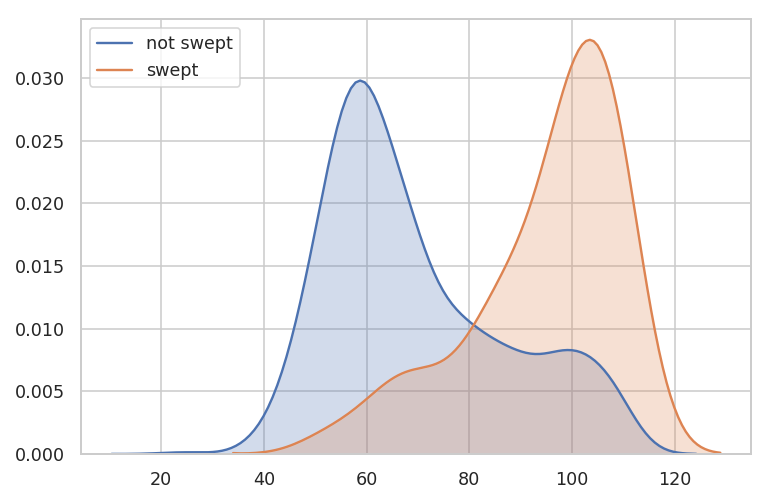

In [91]:
sns.kdeplot(mean_derived_counts.mean_count.loc[lambda sr: ~sr.isnull()], shade=True, label='not swept')
sns.kdeplot(sr.loc[lambda sr: ~sr.isnull()], shade=True, label='swept');

## Load sweep data

In [24]:
sweep_data = pd.read_hdf(ag.results_dir / 'sweep_data.hdf').loc[lambda df: df.not_missing]

## On individual swept haplotypes

In [111]:
moi_dir = '/project/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans/'

with open(moi_dir + 'derived_X.geno') as f:
    arr = np.array([list(line.strip()) for line in f])

arr = np.where(arr == '.', np.nan, arr).astype(float)  

with open(moi_dir + 'derived_X.inds') as f:
    indivs = f.read().split()

with open(moi_dir + 'derived_X.snps') as f:
    snp_pos = map(int, f.read().split())

sr = DataFrame(arr, columns=indivs, index=snp_pos).stack()#.to_frame('is_derived').reset_index().

sr.index.set_names(['pos', 'indiv_1'], inplace=True)
df = sr.to_frame('is_derived').reset_index()

df['start'] = (df.pos // 100000) * 100000
df.head(3)

,pos,indiv_1,is_derived,start
0,399490,S_Spanish-1,0.0,300000
1,399490,B_French-3,0.0,300000
2,399490,S_Papuan-5,0.0,300000


Compute for non-Africans, for positions with derived count above cutoff, the proportion of positions in a window where an individual has the derived variant.

In [117]:
derived_windows = (df
            .loc[~df.indiv_1.isin(regions['Africa'])]
            .groupby('pos')
            .filter(lambda df: df.is_derived.sum() > min_der)
            .groupby(['indiv_1', 'start'])
            .apply(lambda df: pd.Series([df.is_derived.sum(), 
                                         df.is_derived.size, 
                                         df.is_derived.sum() / df.is_derived.size], 
                                         index=['nr_derived', 'nr_total', 'prop_deriv'])
                   )
            .reset_index()
           )
derived_windows.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv
0,B_Australian-4,400000,1.0,3.0,0.333333
1,B_Australian-4,500000,1.0,1.0,1.000000
2,B_Australian-4,1200000,4.0,6.0,0.666667


In [118]:
sweep_data = pd.read_hdf(ag.results_dir / 'sweep_data.hdf')

In [119]:
merged_data = derived_windows.merge(sweep_data, on=['indiv_1', 'start'], how='left')

In [120]:
merged_data.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv,end,pop_1,region_label_1,region_id_1,region_1,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
0,B_Australian-4,400000,1.0,3.0,0.333333,500000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False
1,B_Australian-4,500000,1.0,1.0,1.000000,600000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False
2,B_Australian-4,1200000,4.0,6.0,0.666667,1300000,Australian,Oceania,4,Oceania,...,False,False,True,True,True,True,ambig,ambig,False,False


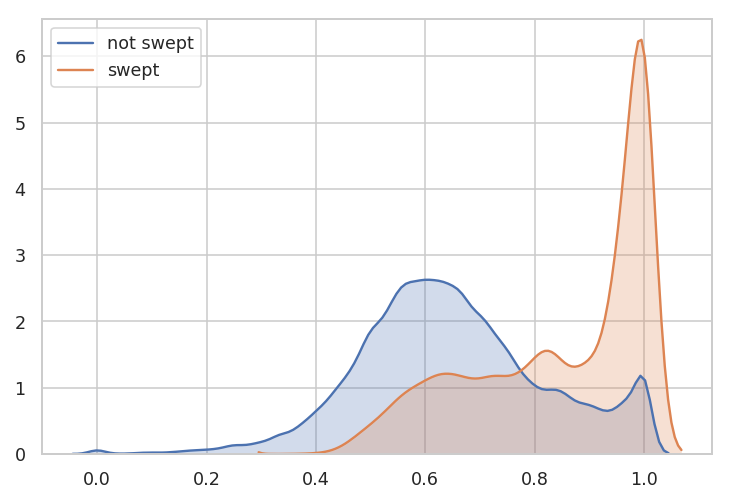

In [139]:
sns.kdeplot(merged_data.loc[merged_data.swept == False].prop_deriv, shade=True, label='not swept')
sns.kdeplot(merged_data.loc[merged_data.swept == True].prop_deriv, shade=True, label='swept');

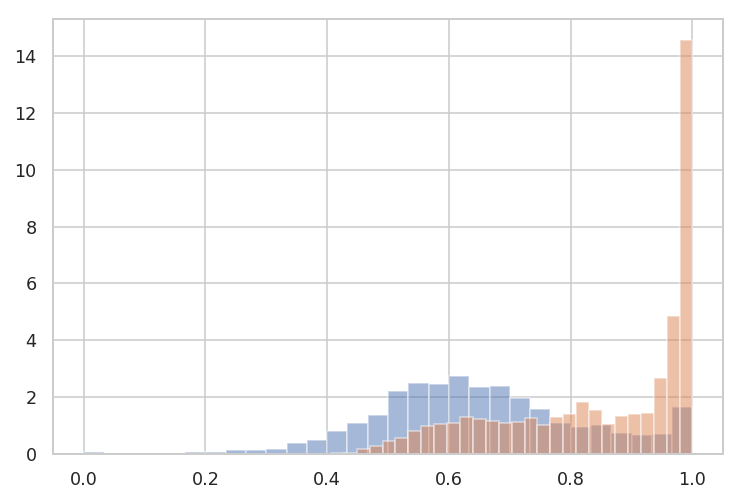

In [135]:
plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='not swept', density=True, alpha=0.5, bins=30)
plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='swept', density=True, alpha=0.5, bins=30);

In [121]:
merged_data.groupby(['swept']).prop_deriv.agg(['mean', 'median', 'sem'])

,mean,median,sem
swept,,,
False,0.649639,0.635294,0.000416
True,0.851363,0.914286,0.001094


scipy.stats.ttest_ind(merged_data.loc[merged_data.swept == True].prop_deriv,
                      merged_data.loc[merged_data.swept == False].prop_deriv)